In [59]:
import pyspark
pyspark.__version__

'3.1.3'

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, lower, trim, date_format, dayofweek, month, hour, minute, datediff, count, avg, max, min, to_date, to_timestamp, sum, when
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
spark = SparkSession.builder.appName('FullPredict')\
        .config("spark.executor.cores",'16')\
        .config("spark.executor.memory", '60g')\
        .getOrCreate()

In [3]:
# load data
df2021 = spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hyrn/2021_Yellow_Taxi_Trip_Data_full.csv")
df2020 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2020_Yellow_Taxi_Trip_Data_full.csv")
df2019 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2019_Yellow_Taxi_Trip_Data_full.csv")

In [4]:
sampled_2021 = df2021.sample(fraction=0.0001, seed=12)
sampled_2020 = df2020.sample(fraction=0.0001, seed=34)
sampled_2019 = df2019.sample(fraction=0.0001, seed=56)

In [5]:
sampled_2021 = sampled_2021.withColumn("Datayear", lit(2021))
sampled_2020 = sampled_2020.withColumn("Datayear", lit(2020))
sampled_2019 = sampled_2019.withColumn("Datayear", lit(2019))

In [6]:
full_df = sampled_2021.union(sampled_2020).union(sampled_2019)

In [7]:
# partition

#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id()).groupBy("partitionId").count()\
        .orderBy(F.asc("count"))\
        .show(num)

In [8]:
#number of partitions
full_df.rdd.getNumPartitions()

103

In [9]:
#re-partition the data to evenly distributed across 103 partitions
full_df = full_df.repartition(32)
displaypartitions(full_df)

Partitions: 32


+-----------+-----+
|partitionId|count|
+-----------+-----+
|         23|  385|
|         22|  389|
|         21|  396|
|         20|  399|
|         19|  404|
|         18|  406|
|         17|  409|
|         16|  410|
|         15|  413|
|         14|  421|
|         13|  425|
|         12|  427|
|         11|  433|
|         10|  437|
|          9|  439|
|          8|  441|
|          7|  444|
|          6|  444|
|          5|  447|
|          4|  452|
|          3|  458|
|          2|  460|
|          1|  461|
|          0|  463|
|         31|  466|
|         30|  467|
|         29|  468|
|         28|  471|
|         27|  477|
|         26|  482|
|         25|  483|
|         24|  485|
+-----------+-----+



In [10]:
# change to date type
full_df = full_df.withColumn("parsed_pickup_datetime", to_timestamp("tpep_pickup_datetime", "MM/dd/yyyy hh:mm:ss a"))
full_df = full_df.withColumn("parsed_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "MM/dd/yyyy hh:mm:ss a"))

# Extract the hour, month, day from pickup time
full_df = full_df.withColumn("pickup_hour", hour("parsed_pickup_datetime"))
full_df = full_df.withColumn("pickup_month", month("parsed_pickup_datetime"))
full_df = full_df.withColumn("pickup_dayofweek", dayofweek("parsed_pickup_datetime"))

In [11]:
# Calculate trip time
full_df = full_df.withColumn("Dur", datediff("parsed_dropoff_datetime", "parsed_pickup_datetime") * 24 * 60 +hour("parsed_dropoff_datetime")* 60-hour("parsed_pickup_datetime")*60
+ minute("parsed_dropoff_datetime") - minute("parsed_pickup_datetime"))

In [12]:
# Calculate speed
full_df = full_df.withColumn("speed", col("Dur")/col("trip_distance"))

In [13]:
# Create a dummy variable of weekday
full_df = full_df.withColumn("pickup_weekday", when((full_df["pickup_dayofweek"] >= 2) & (full_df["pickup_dayofweek"] <= 6), 1).otherwise(0))

In [14]:
# Create a season variable
full_df = full_df.withColumn(
    "season",
    when((full_df.pickup_month <= 2) | (full_df.pickup_month == 12), 1)
    .when((full_df.pickup_month >= 3) & (full_df.pickup_month <= 5), 2)
    .when((full_df.pickup_month >= 6) & (full_df.pickup_month <= 8), 3)
    .otherwise(4),
)

In [15]:
# Create a dummy variable of long_trip
full_df = full_df.withColumn("long_trip", when(full_df["trip_distance"] >= 30, 1).otherwise(0))

In [16]:
# Filter for fare_amount >=3.0, starting fare
full_df = full_df.filter(condition = col("fare_amount") >= 3.0)
# Filter out extreme points
full_df = full_df.filter((col("trip_distance") >= 0) & (col("trip_distance") < 500) & (col("fare_amount") < 400))

In [17]:
# logarithm transformation fare amount, tip amount, trip distance
from pyspark.sql.functions import log1p

# Add a new column with log-transformed fare_amount values
full_df = full_df.withColumn("lfare_amount", log1p(full_df["fare_amount"]))
full_df = full_df.withColumn("ltip_amount", log1p(full_df["tip_amount"]))
full_df = full_df.withColumn("ltrip_distance", log1p(full_df["trip_distance"]))

# Drop the original fare_amount column
# full_df = full_df.drop("fare_amount","tip_amount","trip_distance")

In [18]:
# Drop useless variables
full_df = full_df.drop('total_amount', 'tpep_pickup_datetime','tpep_dropoff_datetime', 'parsed_pickup_datetime', 'parsed_dropoff_datetime')


In [19]:
# Delete missing values and choose only those virtual values according to the official variable description
filtered_df = full_df.filter(col('VendorID').isin([1,2]))
#filtered_df = filtered_df.withColumn("VendorID", when(filtered_df.VendorID == 1, 0).otherwise(0))
filtered_df = filtered_df.filter(col('store_and_fwd_flag').isin(['N', 'Y']))
filtered_df = filtered_df.filter(col('RatecodeID').isin([1,2,3,4,5,6]))
filtered_df = filtered_df.filter(col('payment_type').isin([1,2,3,4,5]))

In [20]:
# Convert store_and_fwd_flag to a dummy variable
filtered_df = filtered_df.withColumn("store_and_fwd_flag", when(filtered_df.store_and_fwd_flag == "Y", 1).otherwise(0))

In [21]:
filtered_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: integer (nullable = false)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_dayofweek: integer (nullable = true)
 |-- Dur: integer (nullable = true)
 |-- speed: double (nullable = true)
 |-- pickup_weekday: integer (nullable = false)
 |-- season: integer

## Model

In [22]:
#categories = filtered_df.select("PULocationID").distinct()

In [23]:
#categories.describe().show()

In [24]:
# Change "lfare_amount" to "label"
filtered_df = filtered_df.withColumnRenamed("lfare_amount", "label")

In [54]:
index_to_feature = {}
column_to_categories = {}
i = 0

# Iterate over each categorical feature
for column in categorical_columns:
    # Get distinct values for categorical feature
    categories = filtered_df.select(column).distinct().rdd.flatMap(lambda x: x).collect()
    column_to_categories[column] = []
    
    # For each category in the categorical feature
    for category in categories:
        column_to_categories[column].append(category)
        # Assign an index to the category
        index_to_feature[i] = f"{column}_{category}"
        i += 1

# Add the numerical features to the dictionary
for column in numerical_columns:
    index_to_feature[i] = column
    i += 1

# Get feature names
feature_names = [index_to_feature[i] for i in range(len(index_to_feature))]

In [55]:
# One-hot encoding
categorical_columns = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type',
                       'season','pickup_dayofweek','Datayear'] # categorical columns
numerical_columns = ['passenger_count','store_and_fwd_flag', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 
                                                                      'congestion_surcharge', 'pickup_hour', 'pickup_month',
                                                                      'Dur', 'pickup_weekday', 'long_trip', 
                                                                      'ltip_amount', "ltrip_distance", "speed"]

indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep")
  for c in categorical_columns
]

encoders = [
  OneHotEncoder(inputCol=indexer.getOutputCol(),
                outputCol="{0}_encoded".format(indexer.getOutputCol()))
  for indexer in indexers
]

#encoders = [
#  OneHotEncoder(inputCol=c,
#                outputCol="{0}_encoded".format(c))
#  for c in categorical_columns
#]

assemblerInputs = [encoder.getOutputCol() for encoder in encoders] + ['passenger_count','store_and_fwd_flag',
                                                                      'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 
                                                                      'congestion_surcharge', 'pickup_hour', 'pickup_month',
                                                                      'Dur', 'pickup_weekday', 'long_trip', 
                                                                      'ltip_amount', "ltrip_distance", "speed"]

vectorAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid="keep")


### Linear Regression

In [145]:
# Define the model: Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="label")

# Create the evaluator
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')

# pipeline = Pipeline(stages=indexers + encoders + [vectorAssembler, lr])
pipeline1 = Pipeline(stages = indexers + encoders)
pipeline2 = Pipeline(stages = [vectorAssembler, lr])

# Train the model using the training data
filtered_df2 = pipeline1.fit(filtered_df).transform(filtered_df).fillna(0)
# Split the data into training and testing sets
train_data, test_data = filtered_df2.randomSplit([0.7, 0.3], seed=27)
lrModel = pipeline2.fit(train_data)

# Make predictions on the test data
predictions = lrModel.transform(test_data)

# Evaluate the model using the evaluator
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data:", rmse)

23/05/22 04:02:30 WARN org.apache.spark.ml.util.Instrumentation: [b85e8a12] regParam is zero, which might cause numerical instability and overfitting.
23/05/22 04:02:33 WARN org.apache.spark.ml.util.Instrumentation: [b85e8a12] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Root Mean Squared Error (RMSE) on test data: 0.22262625736880998


In [146]:
predictions = lrModel.transform(train_data)

# Evaluate the model using the evaluator
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on train data:", rmse)

Root Mean Squared Error (RMSE) on train data: 0.19236439574198455


In [163]:
weights = lrModel.stages[-1].coefficients

In [164]:
print(len(weights))

397


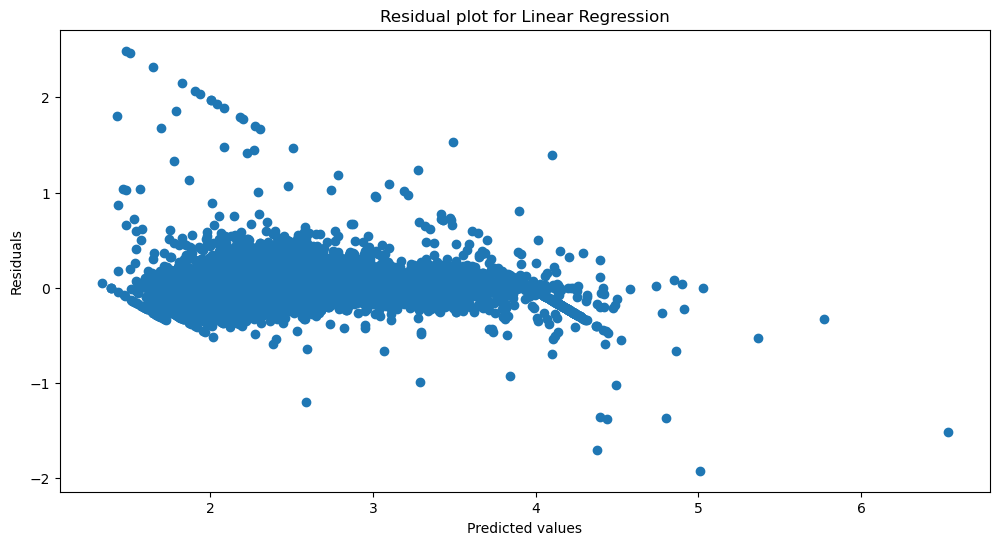

In [149]:
# Visualization
predictions_pd = predictions.select("prediction", "label").toPandas()
predictions_pd['residuals'] = predictions_pd['label'] - predictions_pd['prediction']

# plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(predictions_pd['prediction'], predictions_pd['residuals'])
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual plot for Linear Regression")
plt.show()

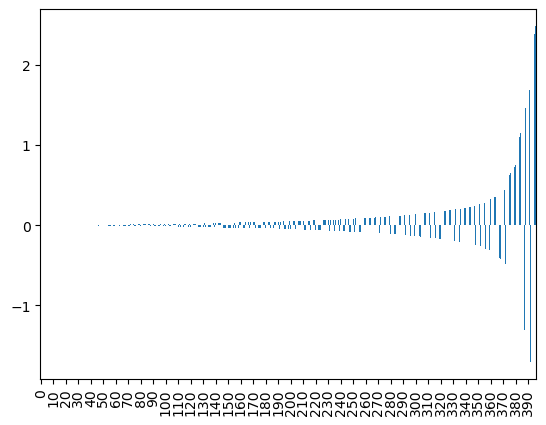

In [165]:
# The relative importance for all the features
weight_features = sorted(list(zip(weights.astype(float), feature_names)), key = lambda tpl: abs(tpl[0]))
weight_features = np.array(weight_features)
ser = pd.Series(map(lambda x: x[0], weight_features), index = range(len(weight_features))).astype(float)
ser.plot.bar(xticks=np.arange(0,len(weight_features), 10))
plt.show()

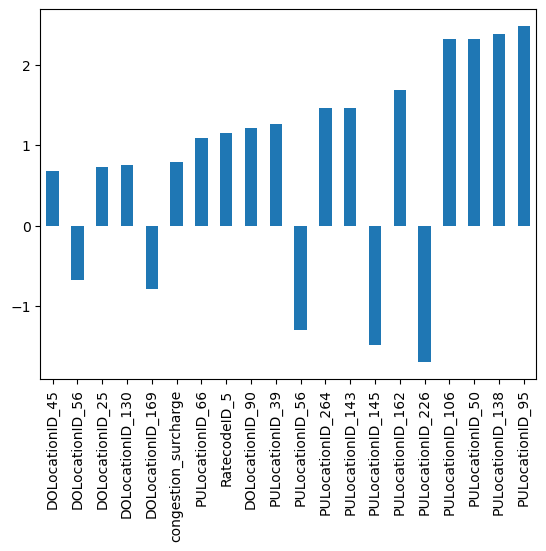

In [167]:
# The least important features
weight_features = sorted(list(zip(weights.astype(float), feature_names)), key = lambda tpl: abs(tpl[0]))
weight_features = np.array(weight_features[-20:])
ser = pd.Series(map(lambda x: x[0], weight_features), index = map(lambda x: x[1], weight_features)).astype(float)
ser.plot.bar()
plt.show()

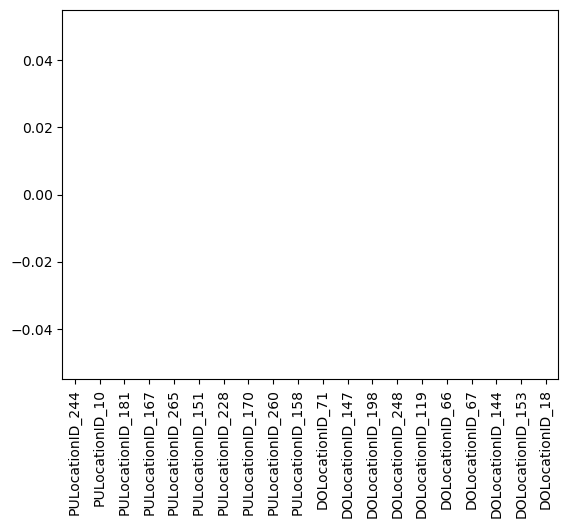

In [168]:
# The most important features
weight_features = sorted(list(zip(weights.astype(float), feature_names)), key = lambda tpl: abs(tpl[0]))
weight_features = np.array(weight_features[:20])
ser = pd.Series(map(lambda x: x[0], weight_features), index = map(lambda x: x[1], weight_features)).astype(float)
ser.plot.bar()
plt.show()

### Linear Regression - Lasso

In [112]:
# Define the model: Linear Regression
lasso = LinearRegression(featuresCol="features", labelCol="label", elasticNetParam=1.0, regParam=0.01)

# Create the evaluator
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')

pipeline = Pipeline(stages= [vectorAssembler, lasso])

# Train the model using the training data
lassoModel = pipeline.fit(train_data)

# Make predictions on the test data
predictions_lasso = lassoModel.transform(test_data)

# Evaluate the model using the evaluator
rmse_lasso = evaluator.evaluate(predictions_lasso)

print("RMSE of lasso on test data:", rmse_lasso)

predictions = lassoModel.transform(train_data)

# Evaluate the model using the evaluator
rmse_lasso = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on train data:", rmse_lasso)

23/05/22 02:15:06 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1684295905877_0008_01_000050 on host: hub-hub-msca-bdp-dphub-student-natalielu-sw-rj6j.c.msca-bdp-student-ap.internal. Exit status: 143. Diagnostics: [2023-05-22 02:15:06.400]Container killed on request. Exit code is 143
[2023-05-22 02:15:06.401]Container exited with a non-zero exit code 143. 
[2023-05-22 02:15:06.413]Killed by external signal
.
23/05/22 02:15:06 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 50 for reason Container from a bad node: container_1684295905877_0008_01_000050 on host: hub-hub-msca-bdp-dphub-student-natalielu-sw-rj6j.c.msca-bdp-student-ap.internal. Exit status: 143. Diagnostics: [2023-05-22 02:15:06.400]Container killed on request. Exit code is 143
[2023-05-22 02:15:06.401]Container exited with a non-zero exit code 143. 
[2023-05-22 02:15:06.413]Killed by external signal
.
23/05/22 0

RMSE of lasso on test data: 0.21942041988156846


Root Mean Squared Error (RMSE) on train data: 0.2097647119042869


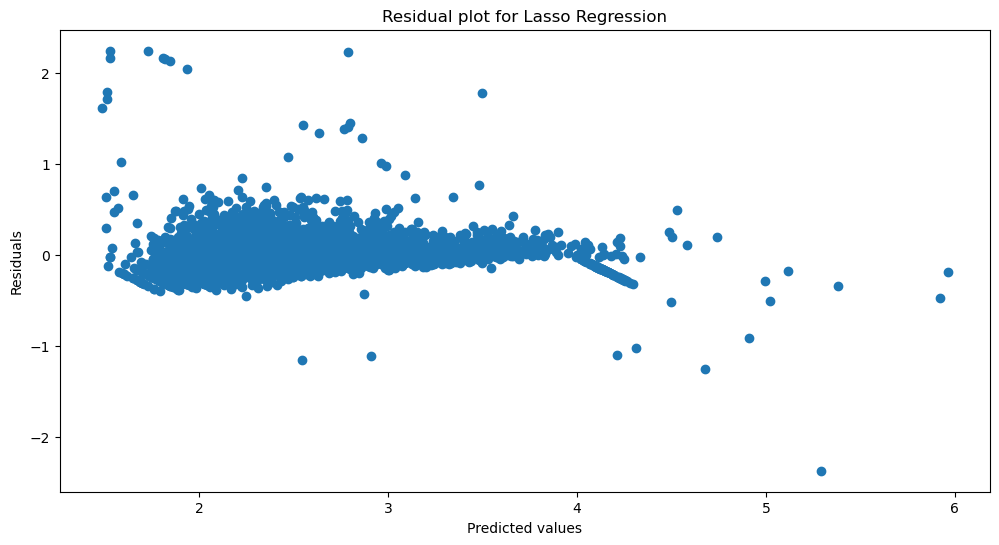

In [ ]:
# Visualization
predictions_pd = predictions_lasso.select("prediction", "label").toPandas()
predictions_pd['residuals'] = predictions_pd['label'] - predictions_pd['prediction']

# plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(predictions_pd['prediction'], predictions_pd['residuals'])
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual plot for Lasso Regression")
plt.show()

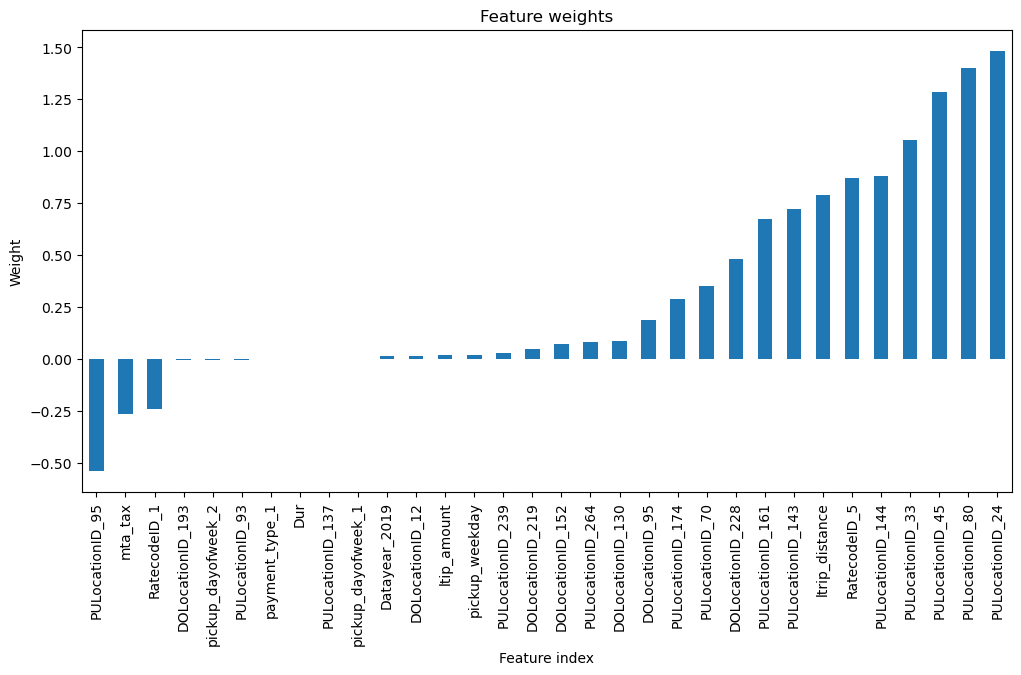

In [120]:
# Extract the lasso model from the pipeline
lasso_model_stage = lassoModel.stages[-1]

# Extract the feature weights
weights = lasso_model_stage.coefficients
weights_features = sorted(list(zip(feature_names, weights)), key=lambda x: x[1])
selected_weights = [weight[1] for weight in weights_features if weight[1] != 0]
selected_weights_name = [weight[0] for weight in weights_features if weight[1] != 0]

# Visualize the weights
plt.figure(figsize=(12, 6))
pd.Series(selected_weights, index = selected_weights_name).plot.bar()
# plt.bar(selected_weights_name, selected_weights)
plt.xlabel('Feature index')
plt.ylabel('Weight')
plt.title('Feature weights')
plt.show()

### Random Forest

In [173]:
# Create a Random Forest regressor
train_data, test_data = filtered_df.randomSplit([0.7, 0.3], seed=27)
rf = RandomForestRegressor(featuresCol='features', labelCol='label')

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [250]) \
    .addGrid(rf.maxDepth, [20]) \
    .addGrid(rf.minInfoGain, [0.1]) \
    .build()

# Create the evaluator
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')

# Create a CrossValidator
cv_rf = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # Specify the number of folds for cross-validation

assemblerInputs = categorical_columns + ['passenger_count','store_and_fwd_flag',
                                                                      'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 
                                                                      'congestion_surcharge', 'pickup_hour', 'pickup_month',
                                                                      'Dur', 'pickup_weekday', 'long_trip', 
                                                                      'ltip_amount', "ltrip_distance", "speed"]

vectorAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid="keep")

# Create a pipeline
pipeline = Pipeline(stages= [vectorAssembler, cv_rf])

# Fit the pipeline to the data
rfModel = pipeline.fit(train_data)

In [174]:
# Get the best model's parameters for Random Forest
best_rf_model = rfModel.stages[-1].bestModel
rf_params = best_rf_model.extractParamMap()
    
for key, val in rf_params.items():
    print(f"Random Forest - {key.name}: {val}")

Random Forest - bootstrap: True
Random Forest - cacheNodeIds: False
Random Forest - checkpointInterval: 10
Random Forest - featureSubsetStrategy: auto
Random Forest - featuresCol: features
Random Forest - impurity: variance
Random Forest - labelCol: label
Random Forest - leafCol: 
Random Forest - maxBins: 32
Random Forest - maxDepth: 20
Random Forest - maxMemoryInMB: 256
Random Forest - minInfoGain: 0.1
Random Forest - minInstancesPerNode: 1
Random Forest - minWeightFractionPerNode: 0.0
Random Forest - numTrees: 250
Random Forest - predictionCol: prediction
Random Forest - seed: 2502083311556356884
Random Forest - subsamplingRate: 1.0


In [175]:
# Make predictions
predictions_rf = rfModel.transform(test_data)

# Evaluate the model using the evaluator
rmse_rf = evaluator.evaluate(predictions_rf)
print("Test RMSE of random forest = %g" % rmse_rf)

Test RMSE of random forest = 0.342749


In [176]:
# Make predictions
predictions_rf = rfModel.transform(train_data)

# Evaluate the model using the evaluator
rmse_rf = evaluator.evaluate(predictions_rf)
print("Train RMSE of random forest = %g" % rmse_rf)

Train RMSE of random forest = 0.34677


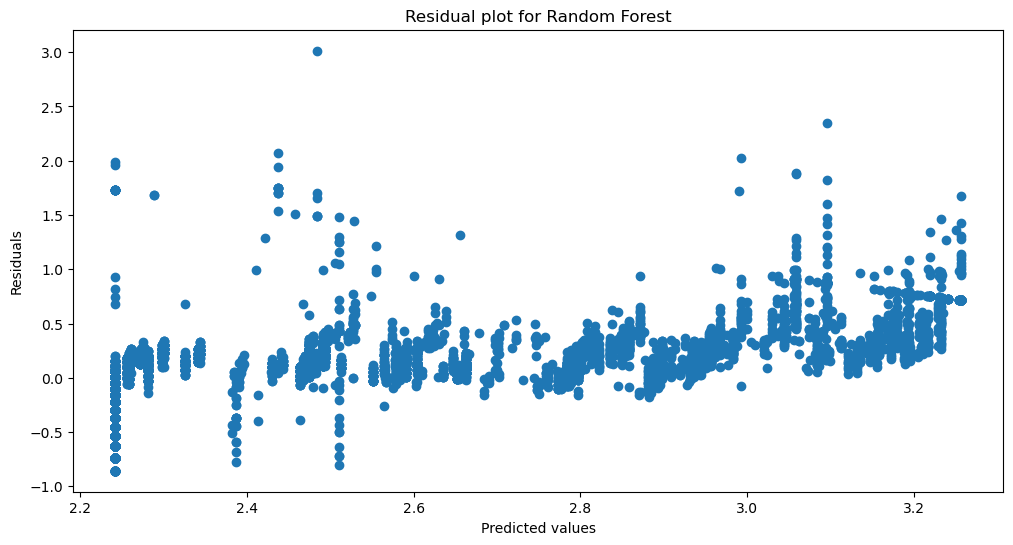

In [177]:
# Visualization
predictions_pd = predictions_rf.select("prediction", "label").toPandas()
predictions_pd['residuals'] = predictions_pd['label'] - predictions_pd['prediction']

# plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(predictions_pd['prediction'], predictions_pd['residuals'])
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual plot for Random Forest")
plt.show()

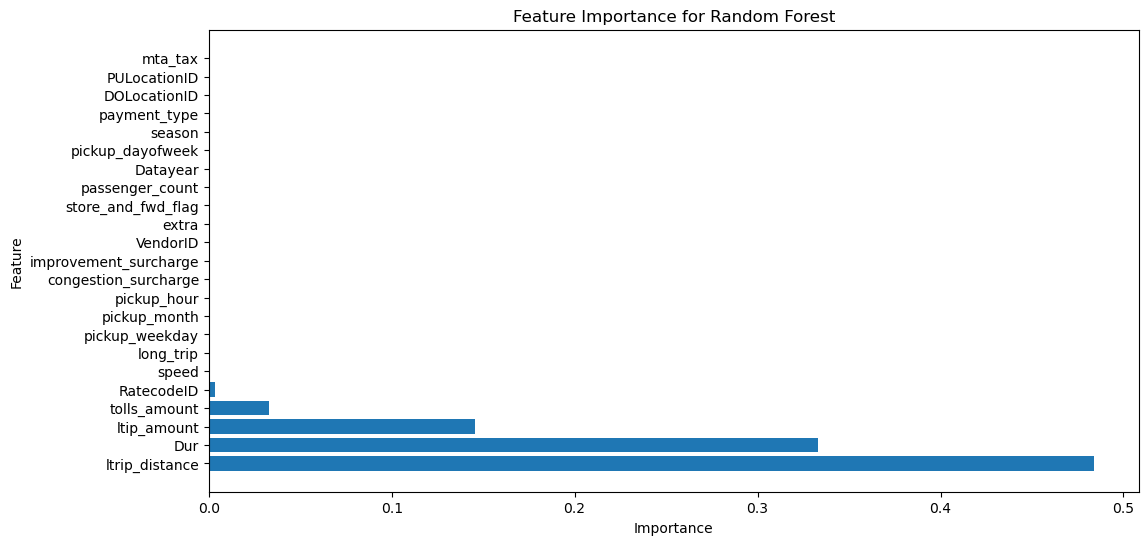

In [178]:
# Visualization

# Extract the feature importances from the trained model
importances = best_rf_model.featureImportances

# Extract the feature names from the VectorAssembler
feature_names = vectorAssembler.getInputCols()

# Combine the feature names and importances into a DataFrame
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


# Sort the DataFrame by the importances
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.barh(df_importances['Feature'], df_importances['Importance'])

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for Random Forest")
plt.show()

In [179]:
from pyspark.ml.linalg import DenseVector

# Get the best random forest model
best_rf_model = rfModel.stages[-1].bestModel

# Get the first tree
first_tree = best_rf_model.trees[0]

# Print the tree structure
print(first_tree.toDebugString)

DecisionTreeRegressionModel: uid=dtr_25650eb1d703, depth=3, numNodes=7, numFeatures=23
  If (feature 20 <= 1.6399666470845582)
   If (feature 21 <= 1.161585863301217)
    Predict: 2.1051569904715137
   Else (feature 21 > 1.161585863301217)
    If (feature 21 <= 1.8817522177262584)
     Predict: 2.6729094400865874
    Else (feature 21 > 1.8817522177262584)
     Predict: 3.5022402532552084
  Else (feature 20 > 1.6399666470845582)
   Predict: 3.3023990353289685

